In [6]:
import torch
from torch.autograd import Variable
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.datasets import fetch_openml
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
print(x.shape,y.shape)

/home/e.gemmell/neural_net_toys/venv/lib/python3.8/site-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


(70000, 784) (70000,)


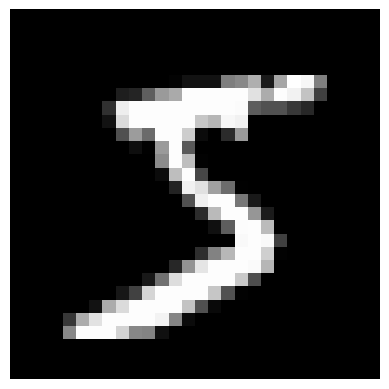

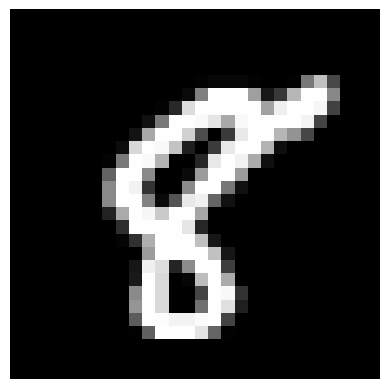

In [7]:
class MnistDataset(torch.utils.data.Dataset):
    def __init__(self, data,targets):
        self.data = data
        self.targets = targets

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        slice_i = torch.tensor(np.take(self.data, indices=idx, axis=0), dtype=torch.float32)
        target = self.targets[idx]
        return slice_i,target

def show_bw_image(img_array):
    plt.imshow(img_array.reshape(28,28), cmap='gray')
    plt.axis('off')
    plt.show()

X = x/255
Y = np.array([int(num) for num in y])
# print(type(Y),type(Y[0]))
train_dataset = MnistDataset(X[:63000],Y[:63000])
val_dataset = MnistDataset(X[63000:],Y[63000:])
show_bw_image(train_dataset[0][0])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False)
show_bw_image(next(iter(train_loader))[0][0])
# data, target = next(iter(train_loader))
# print("data",data,"target",target)

torch.Size([1, 1, 28, 28])
torch.Size([1, 32, 26, 26])
torch.Size([1, 64, 24, 24])
torch.Size([1, 64, 12, 12])
torch.Size([1, 9216])
torch.Size([1, 10])
decoder
torch.Size([1, 128])
torch.Size([1, 9216])
torch.Size([1, 64, 12, 12])
pred torch.Size([1]) tensor([9])
input_image 2


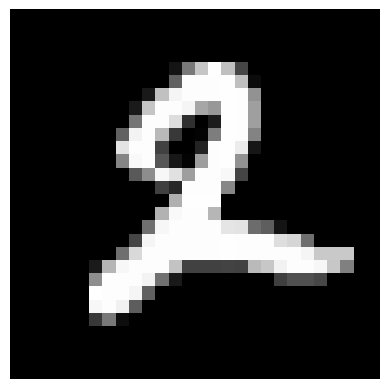

predicted_image tensor([9])


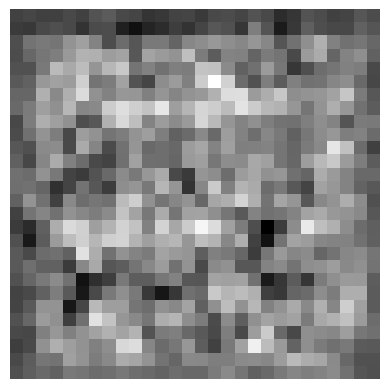

batch 0
torch.Size([8, 1, 28, 28])
torch.Size([8, 32, 26, 26])
torch.Size([8, 64, 24, 24])
torch.Size([8, 64, 12, 12])
torch.Size([8, 9216])
torch.Size([8, 10])
decoder
torch.Size([8, 128])
torch.Size([8, 9216])
torch.Size([8, 64, 12, 12])


TypeError: cross_entropy_loss(): argument 'input' (position 1) must be Tensor, not tuple

In [24]:
class simple_autoencoder(torch.nn.Module):
    def __init__(self):
        super(simple_autoencoder, self).__init__()

        self.enc_conv1 = nn.Conv2d(1, 32, 3, 1)
        self.enc_conv2 = nn.Conv2d(32, 64, 3, 1)
        self.enc_dropout1 = nn.Dropout(0.25)
        self.enc_dropout2 = nn.Dropout(0.5)
        self.enc_fc1 = nn.Linear(9216, 128)
        self.enc_fc2 = nn.Linear(128, 10)

        self.dec_fc1 = nn.Linear(10,128)
        self.dec_fc2 = nn.Linear(128,9216)
        self.dec_dropout1 = nn.Dropout(0.5)
        self.dec_dropout2 = nn.Dropout(0.25)
        self.dec_deconv1 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1)
        self.dec_deconv2 = nn.ConvTranspose2d(32, 1, kernel_size=3, stride=1)


        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')


    def encoder(self,input):
        x = input.view(-1,1,28,28)
        print(x.shape)
        x = self.enc_conv1(x) # now a (batch_size, 32, 26, 26) sized tensor
        print(x.shape)
        x = F.relu(x)
        x = self.enc_conv2(x) # now a (batch_size, 64,24,24) sized tensor
        print(x.shape)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)# now a (batch_size, 64,12,12) sized tensor
        print(x.shape)
        x = self.enc_dropout1(x)
        x = torch.flatten(x, 1)# now a 9216
        print(x.shape)
        x = self.enc_fc1(x)
        x = F.relu(x)
        x = self.enc_dropout2(x)
        x = self.enc_fc2(x)
        print(x.shape)
        latent = F.relu(x)
        return latent

    def decoder(self, latent):
        print("decoder")
        x = self.dec_fc1(latent)
        print(x.shape)
        x = F.relu(x)
        x = self.dec_dropout1(x)
        x = self.dec_fc2(x)
        print(x.shape)
        x = F.relu(x)
        x = self.dec_dropout2(x)
        x = x.view(-1,64,12,12)
        print(x.shape)
        x = self.upsample(x)
        x = self.dec_deconv1(x)
        x = F.relu(x)
        x = self.dec_deconv2(x)
        x = F.relu(x)
        x = torch.flatten(x,1)
        return x
        
    def forward(self, input):
        
        latent = self.encoder(input)
        x = self.decoder(latent)

        return latent, x

    def generate_image_from_one_hot(self,latent):
        return self.decoder(latent)

def visualise_prediction(model, batch,index = 0):
    data,label = batch
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient tracking for efficiency
        input_cpu = torch.tensor(np.expand_dims(data, axis=0), dtype=torch.float32)
        input = input_cpu.to(device)
        # input = data
        # print("input",input.shape,input)
        # predicted_output,pred_label = model(input)
        pred_label, predicted_image = model(input)
        pred_label = pred_label.cpu().argmax(dim=1)
        predicted_image = predicted_image.cpu()
        # predicted_output = predicted_output.numpy()[0]
        print("pred",pred_label.shape,pred_label)
        print("input_image", label)
        show_bw_image(input_cpu)

        print("predicted_image", pred_label)
        show_bw_image(predicted_image)

def generate_image_from_one_hot(model, number = None,one_hot = None):
    if number or number == 0:
            print(f"generating image for number {number}")
            one_hot = [0] * 10
            one_hot[number] = 1
    one_hot = torch.tensor(one_hot, dtype=torch.float32)
    # print("onehot",type(one_hot),one_hot.shape)
    model.eval()
    with torch.no_grad():
        predicted_output = model.generate_image_from_one_hot(one_hot)
        predicted_output = predicted_output.numpy()
        print(predicted_output.shape)
        show_bw_image(predicted_output)
        
def plot_losses(val_losses,train_losses):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
def Validate(model, val_loader):
    MSE_loss = nn.MSELoss()
    CE_loss = nn.CrossEntropyLoss()
    model.eval()
    losses = []
    correct_guesses = 0
    total_guesses = 0
    with torch.no_grad():
        for batch in val_loader:
            input,target = batch
            one_hot_target = F.one_hot(target, num_classes=10).float()
            output, latent = model(input)
            # print("latent shape",latent.shape)
            # print("latent argax", latent.argmax(axis = 1))
            
            for i, pred in enumerate(latent.argmax(axis = 1)):
                if pred == target[i]:
                    correct_guesses += 1
                total_guesses += 1
            # mse_loss = MSE_loss(output, input)
            ce_loss = CE_loss(latent, one_hot_target)
            loss = ce_loss
            losses.append(loss.item())
    # print("total",total_guesses, "correct", correct_guesses)
    return np.mean(losses), (correct_guesses/total_guesses)
    
def Train(model,train_loader, val_loader, epochs,lr):
    MSE_loss = nn.MSELoss()
    CE_loss = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    gradients = []
    epoch_val_losses = []
    epoch_train_losses = []
    epoch_val_accuracies = []
    for epoch in range(epochs):
        model.train()
        losses = []
        for i,batch in enumerate(train_loader):
            print("batch",i)
            input,target = batch
            input = input.to(device)
            targets = target.to(device)
            # print("input",input.shape)
            # print("target", type(target))
            target = F.one_hot(target, num_classes=10).float()

            optimizer.zero_grad() #sets initial gradients to 0 for security purposes
        
            # output, latent = model(input)
            latent = model(input)
            # print("latent",latent.shape,"target",target.shape)
            # mse_loss = MSE_loss(output, input)
            ce_loss = CE_loss(latent, target)
            loss = ce_loss
            losses.append(loss.item())
            loss.backward()
            optimizer.step()
        val_loss,val_accuracy = Validate(model, val_loader)
        epoch_val_accuracies.append(val_accuracy)
        epoch_val_losses.append(val_loss)
        epoch_train_losses.append(np.mean(losses))
        # print('epoch {}, loss {}'.format(epoch, loss.item()))
        print(f'epoch {epoch},accuracy {val_accuracy}, validation loss {epoch_val_losses[-1]}, train loss {epoch_train_losses[-1]}')

    plot_losses(epoch_val_losses,epoch_train_losses)  


    
learning_rate = 0.0001
num_epochs = 30

model = simple_autoencoder().to(device)
visualise_prediction(model,val_dataset[random.randrange(10)])
# generate_image_from_one_hot(model,number = 0)
Train(model,train_loader, val_loader, num_epochs,learning_rate)
visualise_prediction(model,val_dataset[random.randrange(10)])
# generate_image_from_one_hot(model,number = 0)


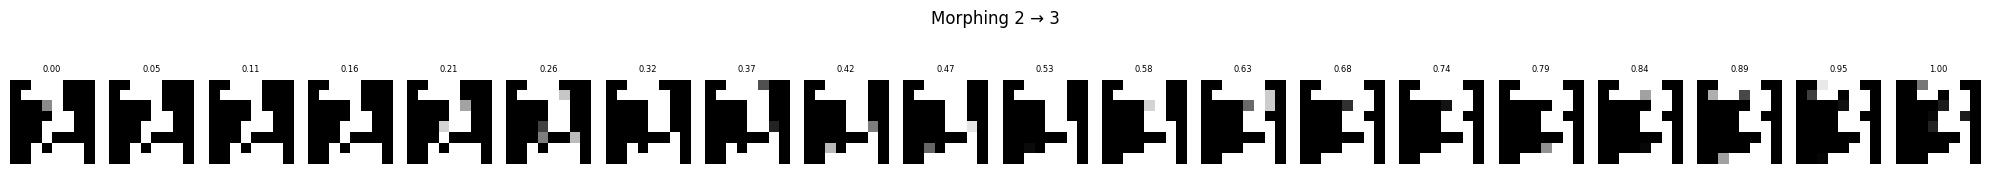

In [50]:
import matplotlib.pyplot as plt
import torch
import numpy as np

def morph_in_grid(model, class_from, class_to, steps=20):
    # One-hot vectors
    vec_from = torch.zeros(10)
    vec_from[class_from] = 1.0

    vec_to = torch.zeros(10)
    vec_to[class_to] = 1.0

    fig, axes = plt.subplots(1, steps, figsize=(steps, 2))

    for i in range(steps):
        alpha = i / (steps - 1)
        interp = (1 - alpha) * vec_from + alpha * vec_to
        with torch.no_grad():
            output = model.decoder(interp.unsqueeze(0)).numpy().reshape(8, 8)
        axes[i].imshow(output, cmap='gray', vmin=0, vmax=1)
        axes[i].axis('off')
        axes[i].set_title(f"{alpha:.2f}", fontsize=6)

    fig.suptitle(f"Morphing {class_from} → {class_to}")
    plt.tight_layout()
    plt.show()

morph_in_grid(model, class_from=2, class_to=3)


tensor([ 0.,  4., 16., 15.,  2.,  0.,  0.,  0.,  0., 11., 15., 15.,  7.,  0.,
         0.,  0.,  0.,  9., 10.,  6., 14.,  0.,  0.,  0.,  0.,  0.,  0.,  7.,
        15.,  0.,  0.,  0.,  0.,  0.,  0., 13., 10.,  0.,  0.,  0.,  0.,  0.,
         1., 16.,  7.,  2.,  2.,  0.,  0.,  1., 12., 16., 15., 16., 15.,  0.,
         0.,  4., 16., 16., 16., 12., 11.,  0.])
input_image 2


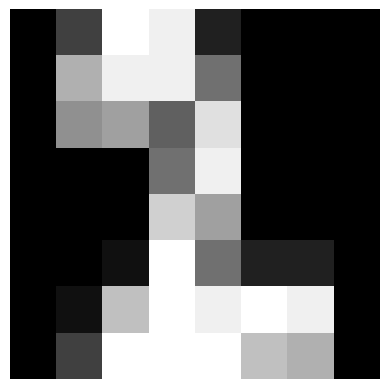

predicted_image tensor([2])


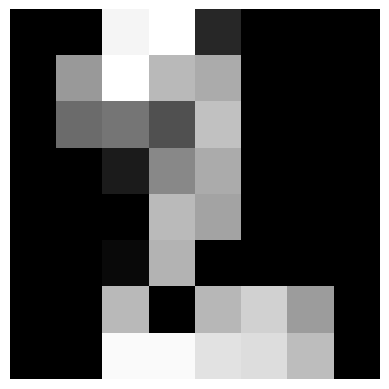

tensor([ 0.,  0.,  2., 13., 16., 16.,  7.,  0.,  0.,  0., 12., 15., 12., 16.,
        10.,  0.,  0.,  0., 16.,  9.,  0., 14.,  6.,  0.,  0.,  0.,  3.,  0.,
         4., 16.,  1.,  0.,  0.,  0.,  0., 10., 14., 16.,  6.,  0.,  0.,  0.,
         3., 16., 16., 11.,  2.,  0.,  0.,  0.,  0.,  9., 14.,  0.,  0.,  0.,
         0.,  0.,  2., 15.,  6.,  0.,  0.,  0.])
input_image 7


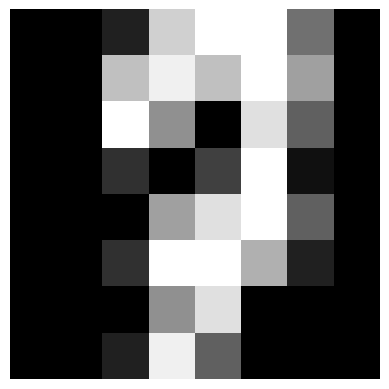

predicted_image tensor([7])


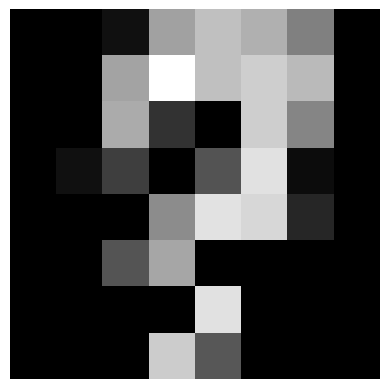

tensor([ 0.,  0.,  0.,  7., 16., 16., 11.,  0.,  0.,  0.,  6., 16., 16., 16.,
        16.,  0.,  0.,  0., 11., 16., 16., 16.,  9.,  0.,  0.,  0.,  2.,  9.,
        11., 14., 10.,  0.,  0.,  0.,  0.,  0.,  0., 10.,  6.,  0.,  0.,  0.,
         0.,  0.,  4., 11.,  1.,  0.,  0.,  0.,  0.,  2., 14.,  2.,  0.,  0.,
         0.,  0.,  0., 11.,  3.,  0.,  0.,  0.])
input_image 9


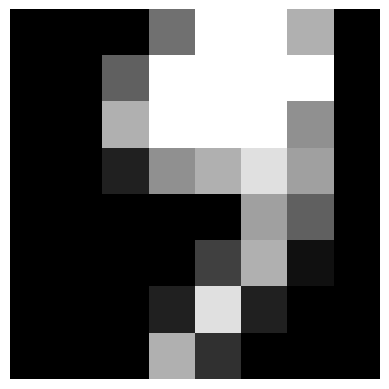

predicted_image tensor([1])


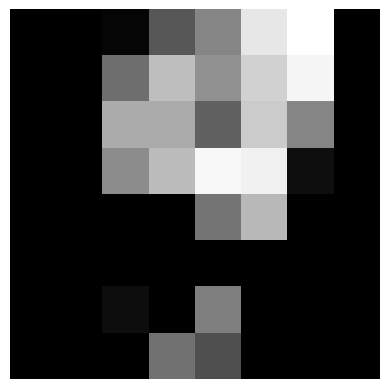

tensor([ 0.,  0.,  0., 11.,  9.,  0.,  0.,  0.,  0.,  0.,  0., 11., 14.,  0.,
         0.,  0.,  0.,  0.,  0., 11., 13.,  0.,  0.,  0.,  0.,  0.,  0., 15.,
        13.,  0.,  0.,  0.,  0.,  0.,  0., 13., 13.,  0.,  0.,  0.,  0.,  0.,
         0., 13.,  9.,  0.,  0.,  0.,  0.,  0.,  0., 10., 10.,  0.,  0.,  0.,
         0.,  0.,  0.,  9., 11.,  0.,  0.,  0.])
input_image 1


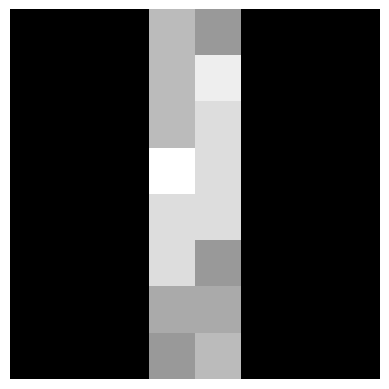

predicted_image tensor([1])


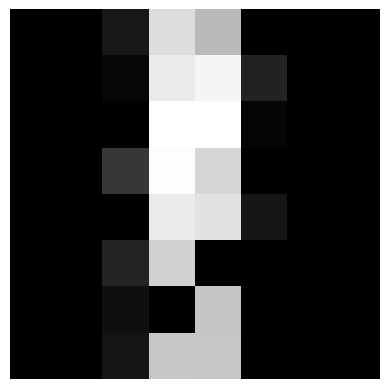

tensor([ 0.,  2., 13., 16., 12.,  0.,  0.,  0.,  0.,  9., 15., 10., 16.,  3.,
         0.,  0.,  0.,  5.,  7.,  5., 16.,  3.,  0.,  0.,  0.,  0.,  0., 10.,
        14.,  0.,  0.,  0.,  0.,  0.,  5., 16.,  7.,  0.,  0.,  0.,  0.,  0.,
        14., 16.,  1.,  3.,  7.,  1.,  0.,  3., 16., 12., 10., 16., 11.,  1.,
         0.,  0., 13., 16., 13.,  7.,  1.,  0.])
input_image 2


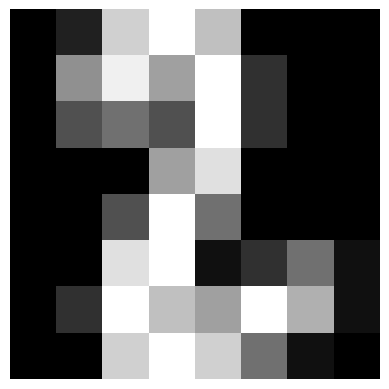

predicted_image tensor([2])


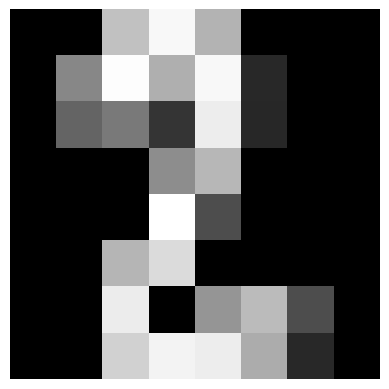

tensor([ 0.,  0.,  4., 14., 11.,  3.,  0.,  0.,  0.,  0., 10., 16., 12., 14.,
         1.,  0.,  0.,  1., 14., 12.,  0., 13.,  3.,  0.,  0.,  5., 16.,  6.,
         0.,  8.,  6.,  0.,  0.,  8., 16.,  0.,  0.,  9.,  8.,  0.,  0.,  7.,
        16.,  3.,  7., 16.,  5.,  0.,  0.,  3., 15., 13., 16., 15.,  2.,  0.,
         0.,  0.,  4., 15., 12.,  2.,  0.,  0.])
input_image 0


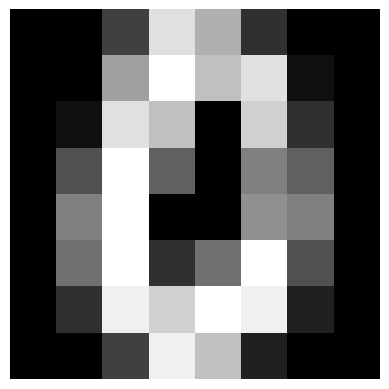

predicted_image tensor([0])


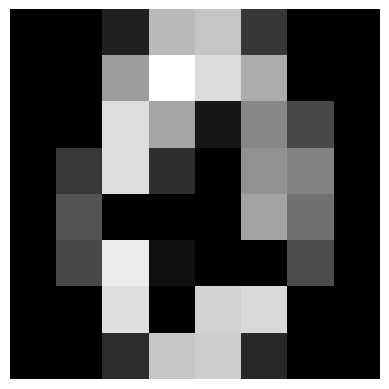

tensor([ 0.,  0.,  8., 12., 11.,  6.,  0.,  0.,  0.,  0.,  8., 16., 16., 13.,
         2.,  0.,  0.,  2., 14., 16., 16., 14.,  2.,  0.,  0.,  2., 13., 16.,
        16.,  8.,  0.,  0.,  0.,  4., 16., 16., 16.,  8.,  0.,  0.,  0.,  4.,
        16., 16., 16., 10.,  0.,  0.,  0.,  1., 11., 16., 16.,  8.,  0.,  0.,
         0.,  0.,  4., 11., 12.,  7.,  0.,  0.])
input_image 1


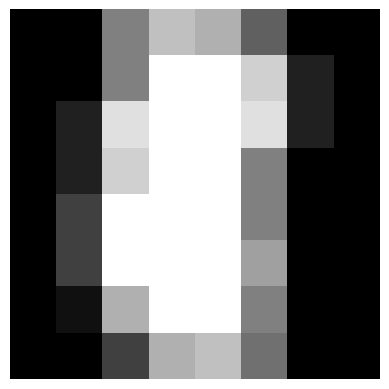

predicted_image tensor([8])


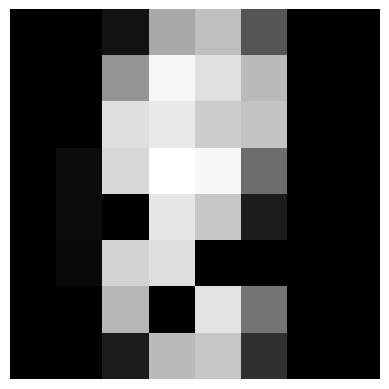

tensor([ 0.,  0.,  5., 14., 14.,  2.,  0.,  0.,  0.,  2., 16., 16., 16.,  7.,
         0.,  0.,  0.,  0.,  7.,  4., 16., 12.,  0.,  0.,  0.,  0.,  1.,  9.,
        16., 16.,  8.,  0.,  0.,  3., 15., 16., 16., 10.,  2.,  0.,  0.,  4.,
        16., 16., 11.,  0.,  0.,  0.,  0.,  0.,  9., 16.,  5.,  0.,  0.,  0.,
         0.,  0.,  9., 13.,  0.,  0.,  0.,  0.])
input_image 7


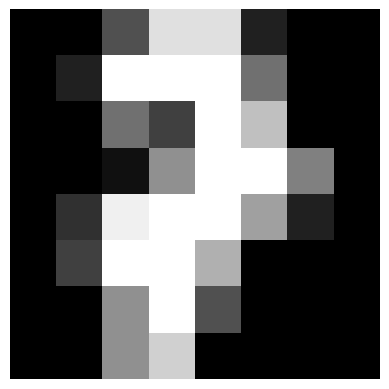

predicted_image tensor([7])


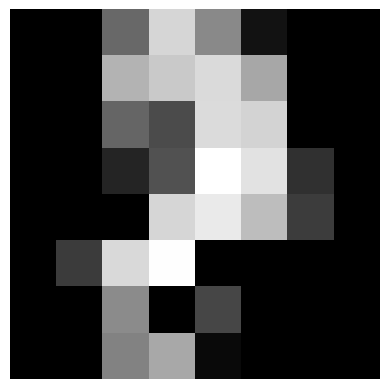

tensor([ 0.,  0.,  8., 16., 11.,  0.,  0.,  0.,  0.,  2., 15.,  8., 16.,  7.,
         0.,  0.,  0.,  3., 13.,  1., 14., 13.,  0.,  0.,  0.,  0., 10., 16.,
        16., 16.,  3.,  0.,  0.,  0.,  0.,  2.,  5., 15.,  4.,  0.,  0.,  0.,
         0.,  0.,  0., 12.,  6.,  0.,  0.,  0.,  5.,  6.,  5., 15.,  4.,  0.,
         0.,  0.,  6., 15., 16., 12.,  1.,  0.])
input_image 9


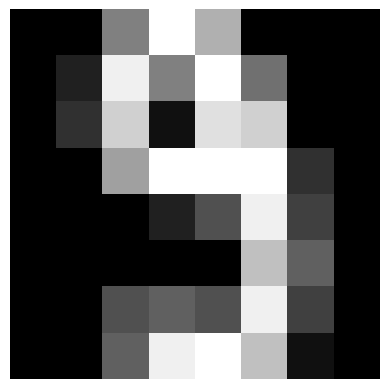

predicted_image tensor([9])


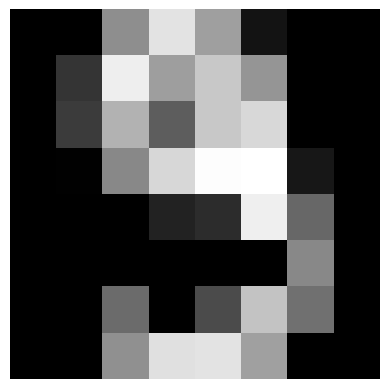

tensor([ 0.,  0., 10., 14.,  8.,  1.,  0.,  0.,  0.,  2., 16., 14.,  6.,  1.,
         0.,  0.,  0.,  0., 15., 15.,  8., 15.,  0.,  0.,  0.,  0.,  5., 16.,
        16., 10.,  0.,  0.,  0.,  0., 12., 15., 15., 12.,  0.,  0.,  0.,  4.,
        16.,  6.,  4., 16.,  6.,  0.,  0.,  8., 16., 10.,  8., 16.,  8.,  0.,
         0.,  1.,  8., 12., 14., 12.,  1.,  0.])
input_image 8


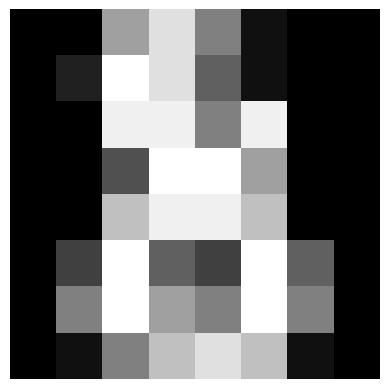

predicted_image tensor([8])


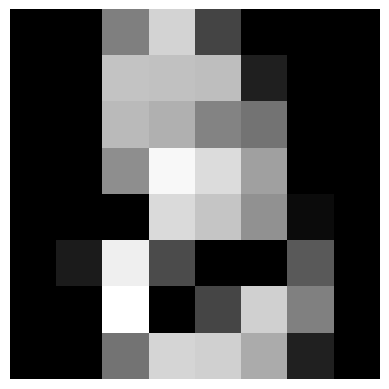

In [51]:
import random

indices = random.sample(range(len(val_dataset)), 10)
for i in indices:
    # print(i)
    # print(val_dataset[i])
    visualise_prediction(model, val_dataset[i])